# 12-14. 프로젝트: 한국어 데이터로 챗봇 만들기

In [18]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds

## Step 1. 데이터 수집하기
송영숙님이 공개한 챗봇 데이터 사용

In [17]:
dataset_filepath = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv'

df = pd.read_csv(dataset_filepath)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## Step 2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [11]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이 거리 만들기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (한글, 알파벳, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [12]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    with open(dataset_filepath, errors='ignore') as file:
        lines = file.readlines()
    
    inputs, outputs = [], []
    with open(dataset_filepath) as file:
        lines = csv.reader(file)
        next(lines)
        for line in lines:
            # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
            inputs.append(preprocess_sentence(line[0]))
            outputs.append(preprocess_sentence(line[1]))
    return inputs, outputs

In [16]:
# 데이터 샘플 수 확인
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전체 샘플 수 : 11823
전체 샘플 수 : 11823
전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


구두점 사이에 공백이 추가된 것을 확인, 이렇게 함으로써 단어를 토크나이징 하는 과정에서 붙어있던 단어들을 하나의 단어로 인식하는 것을 방지한다

## Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

### 토크나이징

#### 1. 단어장 만들기 - SubwordTextEncoder 이용

In [19]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [20]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [21]:
# 시작 토큰과 종료 토큰에 부여된 정수를 출력
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8133]
END_TOKEN의 번호 : [8134]


In [22]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8135


### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 vocabulary를 만들었음

- tokenizer.encode() : 단어 -> 정수로 변환
-          .decode() : 정수 -> 단어 시퀀스로 변환 가능

In [23]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5742, 610, 2483, 4148]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7484, 7, 6249, 97, 1]


In [24]:
questions_len = [len(s.split()) for s in questions]
answers_len = [len(s.split()) for s in answers]
print(f'questions 최대 길이 : {np.max(questions_len)}')
print(f'questions 평균 길이 : {np.mean(questions_len)}')
print(f'answers 최대 길이 : {np.max(answers_len)}')
print(f'answers 평균 길이 : {np.mean(answers_len)}')

questions 최대 길이 : 16
questions 평균 길이 : 3.9391017508246637
answers 최대 길이 : 24
answers 평균 길이 : 4.716146494121627


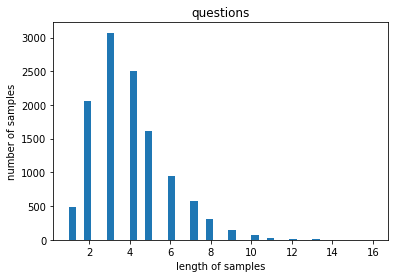

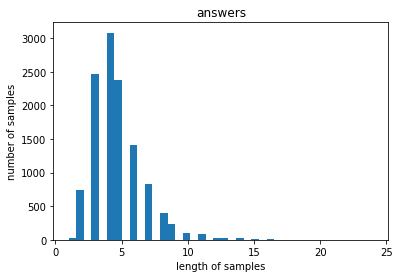

In [25]:
plt.title('questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

최대 길이는 10으로 지정

In [30]:
MAX_LENGTH = 10

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 10 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [31]:
# 단어장 크기와 샘플 개수 확인
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8135
필터링 후의 질문 샘플 개수: 9128
필터링 후의 답변 샘플 개수: 9128


### 3. 교사 강요(Teacher Forcing) 사용하기

질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성한다. 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용

In [32]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

### 1.  포지셔널 인코딩 레이어

임베딩 행렬 + 포지셔널 행렬을 더해서 각 단어 벡터에 위치 정보를 더해준다. 같은 단어라도 포지셔널 인코딩을 해주면 임베딩 벡터값이 달라지므로 가각 다른 위치에 등장했다는 것을 알려준다.

In [37]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


### 2. 스케일드 닷 프로덕트 어텐션

내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구한다.

In [38]:
# 스케일 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    """어텐션 가중치를 계산. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)  # # tf.matmul : 두 텐서를 행렬곱한 결과 텐서를 리턴

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

### 3. 멀티-헤드 어텐션

각각 다른 관점에서 어텐션을 수행하니까 한번만할때보다 정보를 덜 놓친다. 이렇게 병렬로 어텐션 수행하는게 멀티헤드 어텐션 !

In [39]:
# 멀티헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만든다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs


### 4. 패딩 마스킹
자연어 처리에서 패딩이란? 문장의 길이가 다를때, 문장읙 길이를 동일하게 해주는 과정에서 짧으면 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법

In [40]:
# 패딩 마스킹 구현
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

### 5. 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

In [41]:
# 룩 어헤드 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### 6. 인코더

하나의 인코더 층은 크게 두개의 서브층으로 나뉜다 = 셀프 어텐션 + 피드 포워드 신경망

In [42]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
    })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 인코더 층을 쌓아 인코더 만들기

구현한 인코더 층을 임베딩 층과 포지셔널 인코딩을 연결하고, 원하는 만큼 인코더 층을 쌓으면 트랜스포머 인코더가 완성된다

인코더와 디코더 내부에는 layer normalization이라는 테크닉이 들어감(nomalize) num_layers 하이퍼 파라미터로 인코더 층을 쌓는다.

In [43]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 7. 디코더

디코더는 세개의 서브층으로 구성된다

셀프 어텐션 , 인코더-디코더 어텐션, 피드 포워드 신경망


In [44]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )

#### 디코더 층을 쌓아 디코더 만들기
구현한 디코더의 층은 임베딩 층과 포지셔널 인코딩을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓으면 트랜스포머의 디코더가 완성된다

마찬가지로 num_layers로 디코더 층을 쌓는다

In [45]:
# 디코더 층을 쌓아 디코더 만들기
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )

### 8. 앞서 사용한 인코더 함수 디코더 함수 써서 트랜스포머 함수 정의

In [46]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

      # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 9. 모델 생성
하이퍼파라미터 = num_layers, d-Model, units

In [47]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3136768     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 10. 손실 함수(Loss function)
레이블인 시퀀스에 패딩이 되어 있어서 loss계산 시 패딩 마스크 적용

In [49]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 11. 커스텀 된 학습률(Learning rate)
딥러닝 모델학습에서 learning rate는 매우 중요한 파라미터.

최근에는 모델 학습 초기에 러닝레이트를 높였다가 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 커스텀 학습률 스케줄링을 널리 사용한다

커스텀 학습률 스케줄러를 통한 아담 옵티마이즈 사용

In [50]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

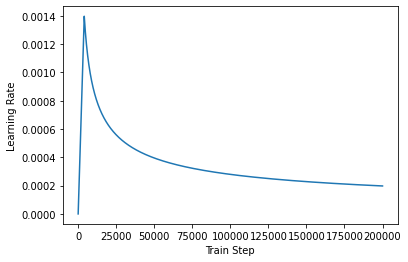

In [51]:
# 학습률 스케줄링 계획 시각화 -> 러닝레이트가 step_num에 비례해서 증가하다가 이후로 감소
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Step 5. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

### 1. 모델 컴파일
손실함수와 커스텀된 학습률을 사용해서 컴파일

In [52]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 2. 훈련하기

In [53]:
EPOCHS = 40 #20 -> 40 으로 늘렸다
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/40
143/143 [==============================] - 10s 26ms/step - loss: 5.6004 - accuracy: 0.0836
Epoch 2/40
143/143 [==============================] - 4s 26ms/step - loss: 4.6940 - accuracy: 0.1982
Epoch 3/40
143/143 [==============================] - 4s 26ms/step - loss: 3.9059 - accuracy: 0.2156
Epoch 4/40
143/143 [==============================] - 4s 26ms/step - loss: 3.5103 - accuracy: 0.2207
Epoch 5/40
143/143 [==============================] - 4s 26ms/step - loss: 3.2836 - accuracy: 0.2315
Epoch 6/40
143/143 [==============================] - 4s 26ms/step - loss: 3.0877 - accuracy: 0.2426
Epoch 7/40
143/143 [==============================] - 4s 26ms/step - loss: 2.8831 - accuracy: 0.2609
Epoch 8/40
143/143 [==============================] - 4s 26ms/step - loss: 2.6660 - accuracy: 0.2827
Epoch 9/40
143/143 [==============================] - 4s 26ms/step - loss: 2.4263 - accuracy: 0.3114
Epoch 10/40
143/143 [==============================] - 4s 26ms/step - loss: 2.1652 - accur

### 3. 챗봇 테스트하기

예측 단계 :

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

싹 다 포함해서 decoder_inference()함수 생성

In [54]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331  86  30  5  1059  7  8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해 decoder_inference()함수를 호출해서 챗봇의 대답을 얻는 sentence_generation()함수를 만든다

In [55]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [57]:
# 임의의 문장으로부터 대답을 얻어보자 !
sentence_generation('안녕?')

입력 : 안녕?
출력 : 안녕하세요 .


'안녕하세요 .'

In [58]:
sentence_generation('게임 같이 할래?')

입력 : 게임 같이 할래?
출력 : 호감을 표현해보세요 .


'호감을 표현해보세요 .'

In [59]:
sentence_generation('배고파 ㅜㅜ')

입력 : 배고파 ㅜㅜ
출력 : 얼른 맛난 음식 드세요 .


'얼른 맛난 음식 드세요 .'

In [60]:
sentence_generation('넌 뭘 좋아해?')

입력 : 넌 뭘 좋아해?
출력 : 하나라도 있을 거니 열심히 찾아보세요 .


'하나라도 있을 거니 열심히 찾아보세요 .'

### 회고

epoch를 20 -> 40 으로 늘렸더니 loss: 0.0356 - accuracy: 0.6581 로 좋은 결과를 얻을 수 있었다.

- 배고파 => 얼른 맛난 음식 드세요
- 게임 같이 할래? => 호감을 표현해보세요
- 넌 뭘 좋아해? => 하나라도 있을 거니 열심히 찾아보세요 

등의 나름 의미가 통하는 대답을 내놓고 있다는 점이 신기했다. 하지만 모델을 구현하는 것에 있어 많이 공부를 해야할 것 같다. 아직 이해가 부족하다는 것을 이번에 많이 느꼈다.